In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, GRU
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import keras

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets  as tfds
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import plot_model, to_categorical
from keras import backend as K
!pip install keras-lookahead

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
keras.__version__

'2.4.0'

In [31]:
cols = ['EventDescription', 'FailedAssets', 'FailedExplosion', 'FailedOilFilled', 'IncidentCause', 'IncidentConsequence', 'Category']

In [32]:
df2 = pd.read_csv('/content/drive/MyDrive/ESV Data/cleaned_incidents1.csv', usecols=cols)
df2.head()

,EventDescription,FailedAssets,FailedExplosion,FailedOilFilled,IncidentCause,IncidentConsequence,Category
0,A nearby customer reported sparking of electri...,Conductor (ABC),0,0,HVABC cable faulted midspan,Grassfire,OH Cable
1,A contractor reported that he had contacted an...,No failed asset,0,0,Contractor contacted earthing conductor,No Go Zone (contact),Dug up
2,A field crew attending an outage found that a ...,Conductor (bare),0,0,Conductor broke due to rust,Serious risk to public safety (e.g. live condu...,Connection
3,Interfere and vandalism in substation. Unknown...,Indoor,0,2,Vandalism,Loss of supply;Damage to network assets,Other
4,A nearby customer reported that a high load ha...,Service conductor,0,0,Unknown high load contacted LV service cable,No Go Zone (contact);Damage to network assets,Vehicle


In [33]:
df2 = df2.dropna()

In [34]:
#concatenate only the text features
df2['description'] = df2['IncidentCause'] + ' ' + df2['EventDescription'] + ' ' + df2['IncidentConsequence'] + ' ' + df2['FailedAssets']

In [35]:
df2['description']

0       HVABC cable faulted midspan A nearby customer ...
1       Contractor contacted earthing conductor A cont...
2       Conductor broke due to rust A field crew atten...
3       Vandalism Interfere and vandalism in substatio...
4       Unknown high load contacted LV service cable A...
                              ...                        
6499    The likely cause was determined by EIO to be a...
6500    Crane struck line Report received from a resid...
6501    Excessive leakage current Report received of p...
6502    Farm equipment hit pole A customer called to r...
6503    Under Investigation concrete electrical cover ...
Name: description, Length: 6488, dtype: object

In [59]:
df2['Category'].unique() #15 unique
len(df2['Category'].unique())

15

In [37]:
import scipy 
from scipy import stats

le = LabelEncoder()
df2['Category'] = le.fit_transform(df2.Category.astype(str))
df2['Category'].unique()

array([ 9,  5,  3, 10, 14,  6, 12, 11,  4,  2,  1,  0,  8, 13,  7])

In [38]:
#Preprocessing by general cleaning by removing reg expressions, numbers and alphanumericals
import nltk 
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df2['description'] = df2['description'].apply(clean_text)

df2['description']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       hvabc cable faulted midspan nearby customer re...
1       contractor contacted earthing conductor contra...
2       conductor broke due rust field crew attending ...
3       vandalism interfere vandalism substation unkno...
4       unknown high load contacted lv service cable n...
                              ...                        
6499    likely cause determined eio earthing defect wi...
6500    crane struck line report received resident adv...
6501    ecessive leakage current report received pole ...
6502    farm equipment hit pole customer called report...
6503    investigation concrete electrical cover outsid...
Name: description, Length: 6488, dtype: object

In [41]:
max_words = 1000*5 #limiting the max vocabulary to 5000
max_len = 100*1 #Limiting the max word count in a row/sentence to 100
tok = Tokenizer(num_words=max_words,filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True, split=" ",)
tok.fit_on_texts(df2['description']) #tok learns the vocabulary of df2['description']


sequences = tok.texts_to_sequences(df2['description']) #encoding the tokens to integers
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len) #augment the length of words in rows by adding zeros
print(sequences_matrix.shape)


(6488, 100)


In [42]:
#sequences_matrix is converted into a dataframe 
df = pd.DataFrame(sequences_matrix)
#with the use of padsequencing we can see the length throughout the rows are equal, by adding zeros in place of missing words

In [44]:
df['FailedExplosion'] = df2['FailedExplosion']
df['FailedOilFilled'] = df2['FailedOilFilled']
#concatenate 2 numerical columns to the token matrix
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,FailedExplosion,FailedOilFilled
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,949,8,674,592,492,19,4,230,122,259,31,330,5,10,78,48,288,3,674,592,86,6,1,141,668,605,4,12,41,3,288,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,55,119,3,101,4,55,119,8,622,825,31,17,5,10,101,1968,535,1363,4071,661,825,55,119,8,76,7,8,4,12,30,27,21,159,59,47,16,94,70,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3061,1760,968,135,6,149,218,368,423,82,78,356,2556,87,1561,132,103,4,12,30,27,21,159,89,88,53,83,91,24,3,6,24,70,92,73,68,3,18,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,38,81,30,1023,544,81,2557,2757,199,11,190,691,427,38,2080,776,427,38,530,113,1401,4072,597,776,80,64,265,557,1969,38,2757,265,33,15,7,26,20,427,0.0,2.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,78,297,286,150,31,17,5,10,14,9,8,55,81,111,513,8,97,6,4,12,30,27,21,159,145,430,8,509,1621,59,47,16,7,26,20,9,3,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6483,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,119,1022,222,61,108,2652,514,1022,3538,195,2864,195,42,361,241,2446,230,3476,195,2864,195,1789,17,5,130,1,67,185,2,85,2652,171,1890,60,329,136,28,49,0.0,0.0
6484,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,271,2603,393,1563,17,36,5,10,393,325,393,44,66,16,172,223,43,3,1017,1681,136,647,831,393,451,279,54,1,4,12,59,47,16,7,26,20,3,18,0.0,0.0
6485,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,163,131,90,42,35,2,1,13,189,17,5,10,118,52,223,2513,6,1,4,12,30,27,21,7,34,1,2,45,0.0,0.0
6486,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,840,136,114,...,2,76,248,148,65,11,314,50,29,97,144,444,76,132,512,1861,15,444,325,3206,111,5,192,1541,35,162,852,4,7,439,12,7,26,20,3,18,2,45,0.0,0.0


In [46]:
Y = df2['Category']
Y

0        9
1        5
2        3
3       10
4       14
        ..
6499     3
6500    14
6501    11
6502    14
6503     0
Name: Category, Length: 6488, dtype: int64

In [48]:
x_train,x_test,y_train,y_test = train_test_split(df,Y,test_size=0.15, stratify=Y)

In [49]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(5514, 102) (5514,) (974, 102) (974,)


In [54]:
units_mul = 100*2
unique_categories = np.unique(Y)
print(unique_categories)
labels_count = len(unique_categories)
dropout = 0.4

def RNN3():
  model = tf.keras.Sequential()
  

  model.add(Embedding(max_words, units_mul, input_length=x_train.shape[1]))
  model.add(tf.keras.layers.SpatialDropout1D(dropout))
  model.add(layers.Conv1D(units_mul,3,padding='valid',activation='relu',strides=1))
  model.add(layers.MaxPooling1D(pool_size=2))
  model.add(layers.Bidirectional(LSTM(units_mul, dropout=dropout, recurrent_dropout=dropout)))
  model.add(Dense(labels_count, activation='softmax'))
  return model

RNN3().summary()


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 102, 200)          1000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 102, 200)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 200)          120200    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 50, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400)               641600    
_________________________________________________________________
dense_2 (Dense)              (None, 15)                6015      
Total params: 1,767,815
Trainable params: 1,767,815
Non-trainable params:

In [55]:
from keras_lookahead import Lookahead
from keras.callbacks import LearningRateScheduler
optimiser = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
lk = Lookahead(optimiser, sync_period=5, slow_step=0.5, name = 'Lookahead')

#The step decay learning rate
#Step Decay A typical way is to to drop the learning rate by half every 10 epochs 
#https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

def step_decay(epoch):
    initAlpha = 0.01
    factor = 0.25
    dropEvery = 5
    alpha = initAlpha *(factor **np.floor((1 + epoch)/dropEvery))
    return float(alpha)


# train model
model = RNN3()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=lk.optimizer,
              metrics=['accuracy'])
with tf.device('/device:GPU:0'):
  history = model.fit(x_train,y_train, batch_size=128,
                    epochs=10, 
                    validation_split=0.2,
                    callbacks=[LearningRateScheduler(step_decay)])


Epoch 1/10
35/35 [==============================] - 14s 400ms/step - loss: 1.6356 - accuracy: 0.4749 - val_loss: 1.0613 - val_accuracy: 0.6745
Epoch 2/10
35/35 [==============================] - 13s 379ms/step - loss: 0.8220 - accuracy: 0.7465 - val_loss: 0.8335 - val_accuracy: 0.7289
Epoch 3/10
35/35 [==============================] - 14s 386ms/step - loss: 0.5865 - accuracy: 0.8125 - val_loss: 0.7202 - val_accuracy: 0.8005
Epoch 4/10
35/35 [==============================] - 14s 389ms/step - loss: 0.4786 - accuracy: 0.8497 - val_loss: 0.7185 - val_accuracy: 0.8087
Epoch 5/10
35/35 [==============================] - 13s 382ms/step - loss: 0.3340 - accuracy: 0.8968 - val_loss: 0.7325 - val_accuracy: 0.8105
Epoch 6/10
35/35 [==============================] - 13s 386ms/step - loss: 0.2555 - accuracy: 0.9225 - val_loss: 0.7382 - val_accuracy: 0.8132
Epoch 7/10
35/35 [==============================] - 13s 382ms/step - loss: 0.2169 - accuracy: 0.9370 - val_loss: 0.7371 - val_accuracy: 0.8160

In [56]:
accr = model.evaluate(x_test,y_test)
print(accr[1])

31/31 [==============================] - 1s 24ms/step - loss: 0.7866 - accuracy: 0.8029
0.802874743938446


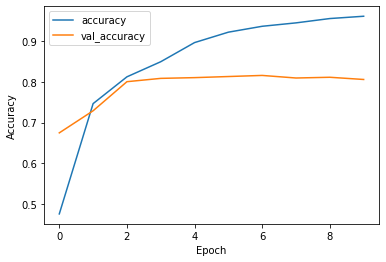

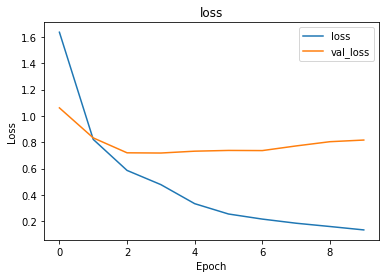

In [57]:
# Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.title('loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

